In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

import re
from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
q = Query.objects.get(pk=6187)
q

<Query: wos_core_fullsearch>

In [4]:
from mordecai import Geoparser
geo = Geoparser()

geo.geoparse("I took the tube from Oxford Circus to London Bridge, via Bank")

[{'country_conf': 0.611725,
  'country_predicted': 'GBR',
  'geo': {'admin1': 'England',
   'country_code3': 'GBR',
   'feature_class': 'S',
   'feature_code': 'BDG',
   'geonameid': '6619889',
   'lat': '51.50821',
   'lon': '-0.08763',
   'place_name': 'London Bridge'},
  'spans': [{'end': 51, 'start': 38}],
  'word': 'London Bridge'}]

In [5]:
django.db.connection.close()
places = []
ccs = []
for d in q.doc_set.all():
    continent = "None"
    if not d.content:
        continue
    if not d.title:
        continue
    t = d.title + " " + d.content
    t = t.split("Copyright (C)")[0] 
    t = re.split("\([C-c]\) [1-2][0-9]{3} Elsevier",t)[0] 
    t = t.split("Published by Elsevier")[0] 
    t = t.split("Copyright. (C)")[0] 
    t = re.split("\. \(C\) [1-2][0-9]{3} ",t)[0] 
    t = re.split("\. \(C\) Copyright",t)[0]     
    
    gp = geo.geoparse(t)
    for p in gp:
        if "geo" in p:
            try:
                a2 = country_alpha3_to_country_alpha2(p["geo"]["country_code3"])
                continent = country_alpha2_to_continent_code(a2)
                ccs.append({
                    "continent": continent,
                    "doc": d.id,
                    "place": p
                })
            except:
                pass
        
df = pd.DataFrame.from_dict(ccs)
print(df.shape)
df.to_csv('../data/places.csv',index=False)
df.head()

(594820, 3)


,continent,doc,place
0,AF,426377,"{'word': 'Minna', 'spans': [{'start': 61, 'end..."
1,AF,426377,"{'word': 'Nigeria', 'spans': [{'start': 81, 'e..."
2,AF,426377,"{'word': 'Nigeria', 'spans': [{'start': 347, '..."
3,AF,426377,"{'word': 'Minna', 'spans': [{'start': 483, 'en..."
4,AS,426377,"{'word': 'Minna city', 'spans': [{'start': 131..."


In [6]:
ldf = df[['doc','continent']].groupby(['doc','continent']).size().reset_index(name="n")
ldf['n'] = 1
wdf = (ldf.pivot(index="doc",columns="continent",values="n")
       .reset_index()
       .rename_axis(None, axis=1)
       .fillna(0)
      )
wdf.to_csv('../data/wide_places.csv',index=False)
wdf

,doc,AF,AN,AS,EU,NA,OC,SA
0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,21,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
203414,1946057,0.0,0.0,0.0,0.0,1.0,0.0,0.0
203415,1946072,0.0,0.0,0.0,0.0,1.0,0.0,0.0
203416,1946073,0.0,0.0,1.0,1.0,0.0,1.0,0.0
203417,1946078,0.0,0.0,1.0,0.0,0.0,0.0,0.0


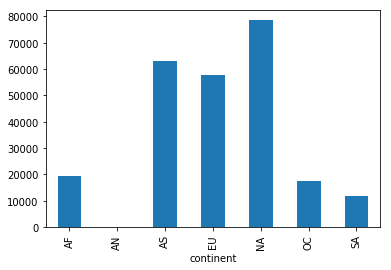

In [7]:
fig,ax = plt.subplots()
ldf.groupby('continent').size().plot.bar()
plt.show()

In [8]:
doctopics = pd.read_csv('../tables/doctopics.csv')
doctopics.head()

,doc_id,score,topic_id
0,1298276,0.003891,170411
1,1298211,0.011146,170411
2,769417,0.002436,170411
3,780152,0.000019,170411
4,1298137,0.000009,170411


In [9]:
print(doctopics.shape)
afdoctopics = doctopics[doctopics['doc_id'].isin(wdf[wdf['AF']==1]['doc'])]
afdoctopics.shape

(18013765, 3)


(901292, 3)

In [10]:
aft = (afdoctopics[['topic_id','score']]
       .groupby('topic_id').sum()
       .reset_index()
       .rename(columns={"score":"africa_score"})
      )
aft['africa_share'] = aft['africa_score'] / aft['africa_score'].sum()
print(aft.shape)
aft.head()

(140, 3)


,topic_id,africa_score,africa_share
0,170408,44.709599,0.017423
1,170409,10.570860,0.004119
2,170410,24.474104,0.009537
3,170411,8.584448,0.003345
4,170412,24.569379,0.009574


In [11]:
run_id = 1861
mdf = pd.read_csv(f'../tables/newness_representation_{run_id}.csv')
tdf = pd.read_csv(f'../tables/topic_info_{run_id}.csv')
tdf = pd.merge(mdf, tdf)
tdf = pd.merge(tdf, aft)
tdf['africa_representation'] = tdf['africa_share'] / tdf['share']
tdf['africa_lrep'] = np.log(tdf['africa_representation'])
tdf.head()

,ipcc_coverage,ipcc_score,ipcc_share,primary_wg,score,share,title,deviation,abs_md,representation,...,lrep,x_q,y_q,oecd_entropy,topic_id,wg_entropy,africa_score,africa_share,africa_representation,africa_lrep
0,0.128797,14.646783,0.004887,2,252.220079,0.006846,"resources, resource management",-0.001959,0.001959,0.713847,...,-0.337087,8,4,-1314.178411,170429,-1348.936281,19.834519,0.007729,1.128956,0.121293
1,0.158433,11.240170,0.003751,2,129.018354,0.003502,"fire, fire",0.000248,0.000248,1.070937,...,0.068534,4,6,-555.582861,170430,-597.864157,11.355198,0.004425,1.263509,0.233893
2,0.176489,27.943361,0.009324,2,302.971623,0.008224,"causality, attribution of effects",0.001100,0.001100,1.133755,...,0.125535,3,7,-1581.574242,170431,-1664.985887,18.500657,0.007209,0.876638,-0.131661
3,0.097683,22.877968,0.007634,1,348.588788,0.009462,"records, long term climate & CO2 records",-0.001828,0.001828,0.806764,...,-0.214724,1,4,-2069.572653,170432,-1985.542905,90.124231,0.035120,3.711617,1.311468
4,0.151926,29.904547,0.009978,1,373.365499,0.010135,"carbon, carbon sources, sinks and flows",-0.000156,0.000156,0.984567,...,-0.015553,4,6,-2202.553212,170433,-2142.196472,15.054050,0.005866,0.578834,-0.546739


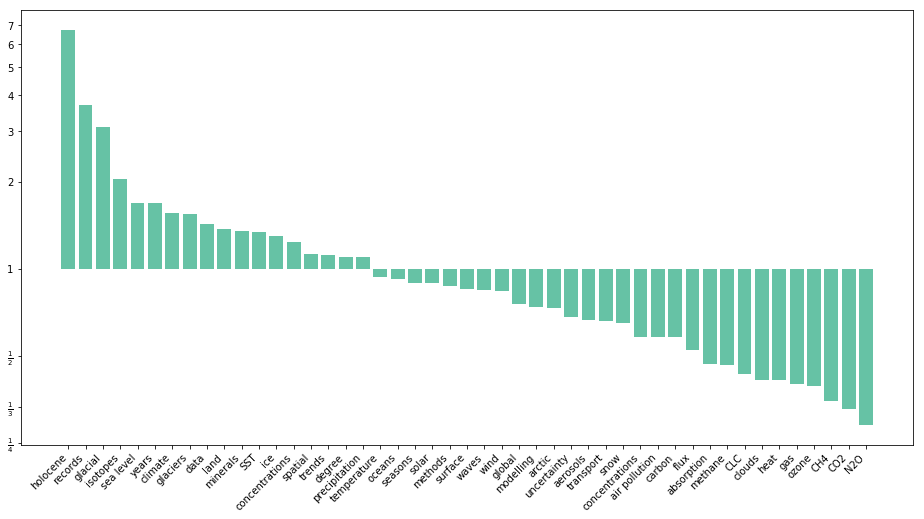

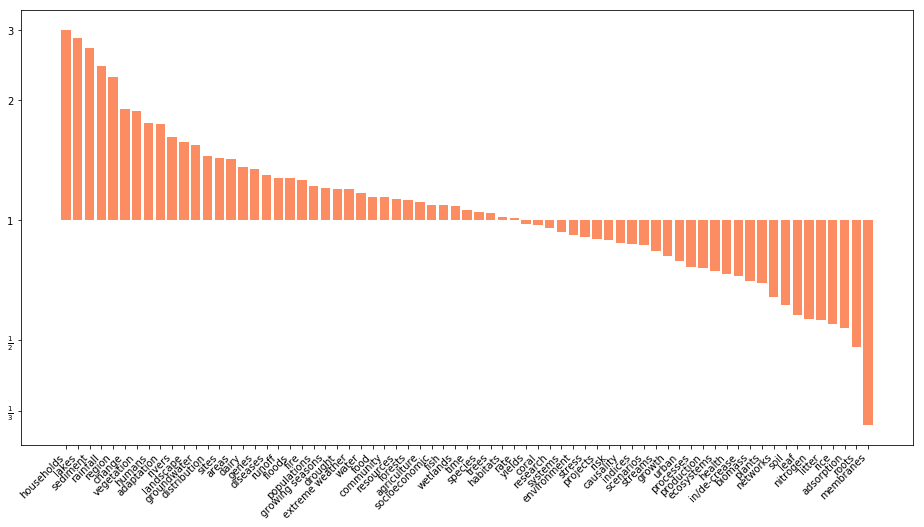

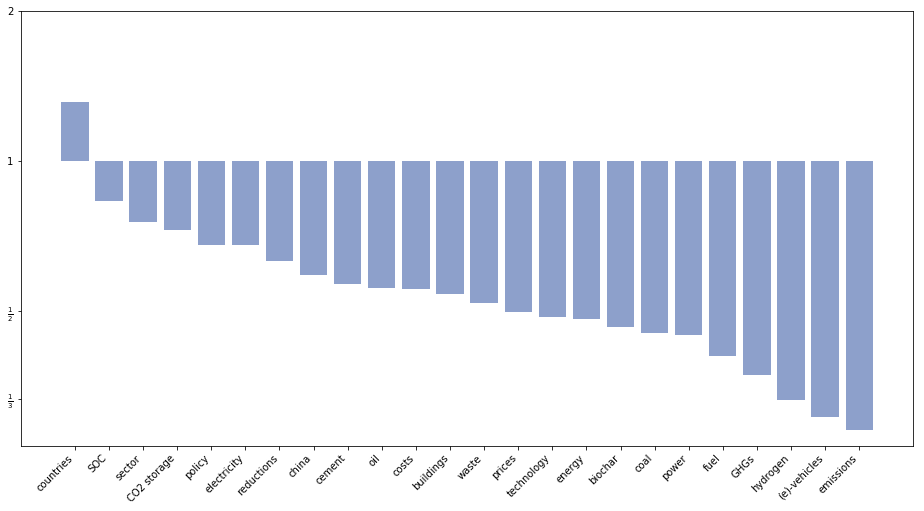

In [12]:
cmap = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}
colors = [cmap[i] for i in mdf['primary_wg']]


def set_log_ticks(fdf, ax, min_y=-8, tight=False, y='lrep'):
    fmax = None
    fmin = None
    rmax = fdf[y].max()
    rmax = ax.get_ylim()[1]
    if fmax:
        rmax = fmax
    rmin = fdf[y].min()
    rmin = ax.get_ylim()[0]
    if fmin:
        rmin = -fmin

    if rmin > -1:
        rmin = -1
    if np.exp(rmax) < 2:
        rmax = np.log(2.1)

    lmin = int(1/np.exp(rmin)//1)*-1
    lmax = int(np.exp(rmax)//1)

    all_ytick_labels = [i for i in range(lmin,lmax+1) if i not in [-1,1]]

    ytick_labels = []

    if tight:
        for x in all_ytick_labels:
            if lmin > min_y:
                ytick_labels.append(x)   
            elif abs(x) in [2,10,50]:
                ytick_labels.append(x)
    else:     
        for x in all_ytick_labels:
            if lmin > min_y:
                ytick_labels.append(x)
            else:
                if abs(x) < 11:
                    if x % 5 == 0 or abs(x)==2:
                        ytick_labels.append(x)
                elif x < 100:
                    if x % 50==0 or abs(x)==20:
                        ytick_labels.append(x)


    yticks = []
    ytick_label_fractions = []
    for x in ytick_labels:
        if x < 0:
            y = np.log(-1/x)
            ytick_label_fractions.append('$\\frac{1}{'+str(abs(x))+'}$')
        elif x==0:
            y = 0
            ytick_label_fractions.append(1)
        else:
            y = np.log(x)
            ytick_label_fractions.append(x)
        yticks.append(y)

    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_label_fractions)   


for name, group in tdf.groupby('primary_wg'):
    group = group.sort_values('africa_lrep', ascending=False).reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(16,8))
    
    #plot_representation(group,ax,nts=10,xspace=2,yspace=0.07)
    plt.xticks(rotation=45,ha="right")
    ax.bar(group.index, group['africa_lrep'], color=cmap[group['primary_wg'][0]])
    ax.set_xticks(group.index)
    ax.set_xticklabels([x.split(',')[0] for x in group['title']])
    set_log_ticks(tdf, ax, y='africa_lrep')
    fig.patch.set_facecolor('white') 
    
    plt.show()